In [2]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt                          #Importiamo tutte le librerie.
import sklearn                  
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
import sklearn.svm as svm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, plot_roc_curve, confusion_matrix, accuracy_score, fbeta_score, f1_score, recall_score, precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
import seaborn as sns
import random


import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_path = 'C:/Users/Nando/Desktop/TesiMaster/Fraud Detection/creditcard.csv'

data = pd.read_csv(dataset_path, na_values = " ", comment='\t', sep=",", skipinitialspace=True)

#Importo il dataset




In [4]:
data.drop('Time', inplace = True, axis = 1)
#Elimino la variabile Time.(la variabile è solo un contatore impostato a zero per la prima operazione)

In [5]:
Normal = data[data.Class == 0]
Fraud = data[data.Class == 1]

In [6]:
train_data = Normal.sample(frac = 0.8, random_state = 8)
test_data = Normal.drop(train_data.index)

In [7]:
test_data = test_data.append(Fraud) #Visto che le frodi non vengono usate nell'addestramento le assegnamo tutte al test set.

In [8]:
train_data.drop('Class', inplace = True, axis = 1)

In [9]:
test_data =test_data.sample(frac=1).reset_index(drop=True)
train_data = train_data.reset_index(drop = True)

In [10]:
test_y = test_data.pop("Class")

In [11]:
#Eseguiamo adesso lo scaling dei dati usando il MinMaxScaler.
train_x = train_data.values
test_x = test_data.values


scaler_x = MinMaxScaler(feature_range=(0,1))  #Scaliamo i dati di training e test utilizzando il MinMax
                                              #Facendo delle prove il MinMax ha dato risultati migliori rispetto allo Standard
scaler_x.fit(train_x)
scaled_train_x = scaler_x.transform(train_x)
scaled_test_x = scaler_x.transform(test_x)


In [29]:

#funzione che costruisce un autoencoder

def autoencoderbuilder(Input_size, Parametri):
        autoencoder = keras.Sequential()
        autoencoder.add(layers.Flatten(input_shape=(Input_size, )))
        for j in range(Parametri[0]):
            autoencoder.add(layers.Dense(units = Parametri[j+1], activation='sigmoid'))

        autoencoder.add(layers.Dense(units = Input_size, activation = 'sigmoid'))   
        autoencoder.compile(optimizer='adam', loss="mse")
        
        return autoencoder
    

In [89]:
def validation(x,Input_size, list):
    best = np.inf
    Model = None
    Parametri = None
    for i in range(len(list)):
        cv = model_selection.KFold(n_splits=5, shuffle = True, random_state = 0)
        early_stopping = callbacks.EarlyStopping(monitor='val_loss', verbose=0, patience= 20, restore_best_weights=True)
        avg_score = 0
        for train_index, test_index in cv.split(x):
            model = autoencoderbuilder(Input_size,list[i])
            fold_train_x, fold_test_x = x[train_index], x[test_index]
            history = model.fit(fold_train_x, fold_train_x,validation_data = (fold_test_x, fold_test_x),callbacks = [early_stopping], batch_size= 32, epochs=100,verbose=0)
            score = model.evaluate(fold_test_x, fold_test_x, verbose = 0)
            avg_score += score
        avg_score = avg_score / 5
        if avg_score < best:
            best = avg_score
            Model = model
            Parametri = list[i]
        
    return history, avg_score, Model, Parametri

In [103]:
lista = [[3,20,15,20], [3,25,20,25],[3,25,15,25],[3,20,10,20],[3,25,10,25]]

In [64]:
dim = len(train_x[0,:])

In [90]:
Storia, Loss, Modello, Parametri = validation(scaled_train_x,dim,lista)

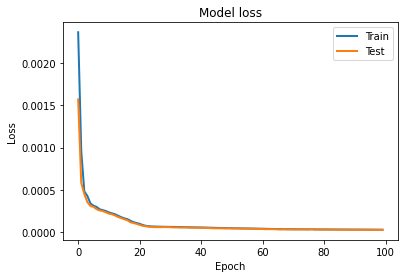

In [93]:
plt.plot(Storia.history['loss'], linewidth=2, label='Train')
plt.plot(Storia.history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')             #Plottiamo l'andamento della loss durante l'addestramento.
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [14]:
test_x_predictions = Modello.predict(scaled_test_x)
mse =  tf.keras.losses.mse(test_x_predictions, scaled_test_x)  
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})                    
TrainError = tf.keras.losses.mse(scaled_train_x,Modello.predict(scaled_train_x))

#Previsione sul test set e calcolo dell'errore sul training per stabilire la threshold


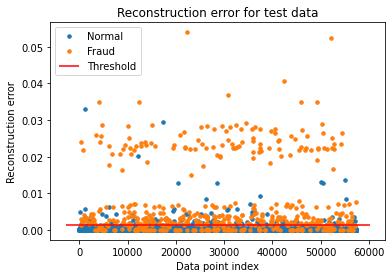

In [15]:
threshold_fixed = np.quantile(TrainError,0.998) #il percentile corrisponde alla percentuale di transazioni fraudolente

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for test data")
plt.ylabel("Reconstruction error")                               
plt.xlabel("Data point index")
plt.show();


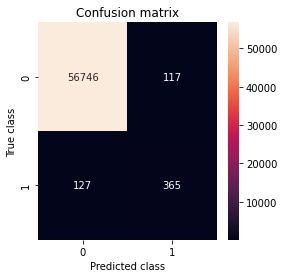

 Accuracy:  0.9957457937407375
 Recall:  0.741869918699187
 Precision:  0.7572614107883817
 F1:  0.7494866529774128


In [16]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')                       #Quantificazione prestazioni del modello nel classificare le transazioni.
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))
print(" F1: ",f1_score(error_df['True_class'], error_df['pred']))

In [72]:
Modello.save("Autoencoder")

INFO:tensorflow:Assets written to: Autoencoder\assets


In [13]:
Modello = keras.models.load_model("Autoencoder")